In [1]:
import path_configs # noqa
import tensorflow as tf
import settings
from datetime import datetime
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
import numpy as np
import librosa
settings.init()
import seaborn as sns
sns.set(font_scale=1.5, font="Arial", style="white")
from modules.ClassifierGenerators import (TrainClassifierGenerator,  # noqa
                                          ValidationClassifierGenerator)  # noqa

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

TRAIN_DATA_LEN: 3720334
VAL_DATA_LEN: 1593071


In [2]:
#assumes that array is not zero
def scaled(tensor):
    return (tensor-tf.math.reduce_min(tensor))/(tf.math.reduce_max(tensor)-tf.
                                                math.reduce_min(tensor))
def scaled_array(array):
    return (array - np.min(array))/(np.max(array) - np.min(array))

import scipy.spatial.distance as dist
def similarity(x1, x2):
    x1 = librosa.feature.mfcc(x1).flatten()
    x2 = scipy.signal.resample(librosa.feature.mfcc(x2).flatten(), len(x1))
    distance = dist.correlation(x1, x2)
    return 1/(1+distance)

from modules.DataPreprocessor import DataLoader
dl = DataLoader()
sample_rate = 48000
window_time = dl.window_time
frame_length = int(48000*window_time/1000)
frame_step = frame_length//4
def reverse_to_audio(db_spec):
    audio_rev_spec = librosa.db_to_power(db_spec, ref=1.0)
    print(
        'reversing'
    )
    return librosa.feature.inverse.mel_to_audio(audio_rev_spec, sr=48000, n_fft=frame_length, hop_length=frame_length//4)

In [3]:
train = pd.read_csv('data_info.csv')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


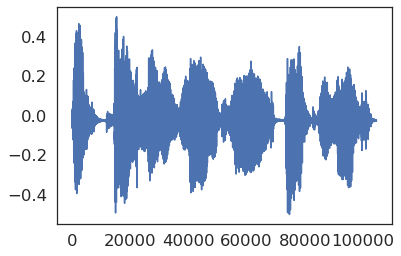

In [4]:
audio = np.array(dl.load_audio_binary(63))
cut_audio = dl.cut_voice(audio)
plt.plot(cut_audio)

In [21]:
from tqdm import tqdm
for gender_name in ['male', 'female']:
    for age_name in ['teens', 'twenties','seventies', 'fifties', 'fourties','thirties', 'sixties', 'eighties', 'nineties']:        
        Path(os.path.join('data', 'images', gender_name, age_name)).mkdir(parents=True, exist_ok=True)

for spec_num in tqdm(np.arange(100)):#38781+1
    spec = dl.make_spectrogram(spec_num)
    paded_spec = dl.pad_spec(spec)
    age = dl.train.iloc[spec_num, 3]
    gender = dl.train.iloc[spec_num, 4]
    for window in np.arange(0, paded_spec.shape[1], 64):
        spec_window = paded_spec[:, window:window + 64]
        name = str('spec_' + str(window//64) + '.png')
        np.save(os.path.join('data', 'images', gender, age, name), spec_window, allow_pickle = False)

100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


In [6]:
(dl.train.length.sum() / dl.train.length.iloc[:100].sum())*11

71.30176630434784

In [37]:
paded_spec[:, 64*2:64*5]

array([[-15.008305, -13.105341, -11.74819 , ..., -19.76819 , -17.674244,
        -21.576172],
       [-15.970488, -14.147499, -12.601236, ..., -20.772522, -18.590248,
        -22.464588],
       [-22.412945, -24.013256, -16.667717, ..., -28.678944, -23.858788,
        -27.162926],
       ...,
       [-53.037895, -53.037895, -53.037895, ..., -53.037895, -53.037895,
        -53.037895],
       [-53.037895, -53.037895, -53.037895, ..., -53.037895, -53.037895,
        -53.037895],
       [-53.037895, -53.037895, -53.037895, ..., -53.037895, -53.037895,
        -53.037895]], dtype=float32)

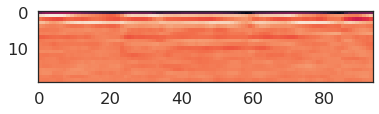

In [146]:
plt.imshow(librosa.feature.mfcc(cut_audio[:48000*], sr=48000))

In [10]:
from scipy.io.wavfile import write

scaled = np.int16(audio/np.max(np.abs(audio)) * 32767)
write('testOG.wav', 48000, scaled)

scaled2 = np.int16(cut_audio/np.max(np.abs(cut_audio)) * 32767)
write('test_recovered.wav', 48000, scaled2)